### Paso 1. Abrir el archivo de datos y leer la información general

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest



In [2]:
df = pd.read_csv("logs_exp_us.csv", sep='\s+')

## Paso 2. Preparar los datos para el análisis

- Cambia el nombre de las columnas de manera que sea conveniente para ti.
- Comprueba los tipos de datos y valores ausentes. Corrige los datos si es necesario.
- Agrega una columna de fecha y hora y una columna separada para las fechas.

In [3]:
#cambiamos nombres de las columnas 
columns = ['evento', 'id_usuario', 'tiempo', 'id_experimento']
df.columns = columns
#convertimos la columna tiempo a formato fecha y hora completa
fechas = pd.to_datetime(df['tiempo'], unit='s', errors='coerce')
df['fecha'] = fechas.dt.date
#convertimos la columna tiempo a formato hora,minuto
df['hora'] = fechas.dt.strftime('%H:%M')

df = df.drop(columns=['tiempo'])
print(df.head())
df.info()


                    evento           id_usuario  id_experimento       fecha  \
0         MainScreenAppear  4575588528974610257             246  2019-07-25   
1         MainScreenAppear  7416695313311560658             246  2019-07-25   
2  PaymentScreenSuccessful  3518123091307005509             248  2019-07-25   
3         CartScreenAppear  3518123091307005509             248  2019-07-25   
4  PaymentScreenSuccessful  6217807653094995999             248  2019-07-25   

    hora  
0  04:43  
1  11:11  
2  11:28  
3  11:28  
4  11:48  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   evento          244126 non-null  object
 1   id_usuario      244126 non-null  int64 
 2   id_experimento  244126 non-null  int64 
 3   fecha           244126 non-null  object
 4   hora            244126 non-null  object
dtypes: int64(2), object(3)
memory

## Paso 3. Estudiar y comprobar los datos

- ¿Cuántos eventos hay en los registros?
- ¿Cuántos usuarios hay en los registros?
- ¿Cuál es el promedio de eventos por usuario?
- ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?
- ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
- Asegúrate de tener usuarios de los tres grupos experimentales.

Total de eventos: 244126
Total de usuarios únicos: 7551
Promedio de eventos por usuario: 32.33028737915508
Fecha mínima: 2019-07-25, Fecha máxima: 2019-08-07


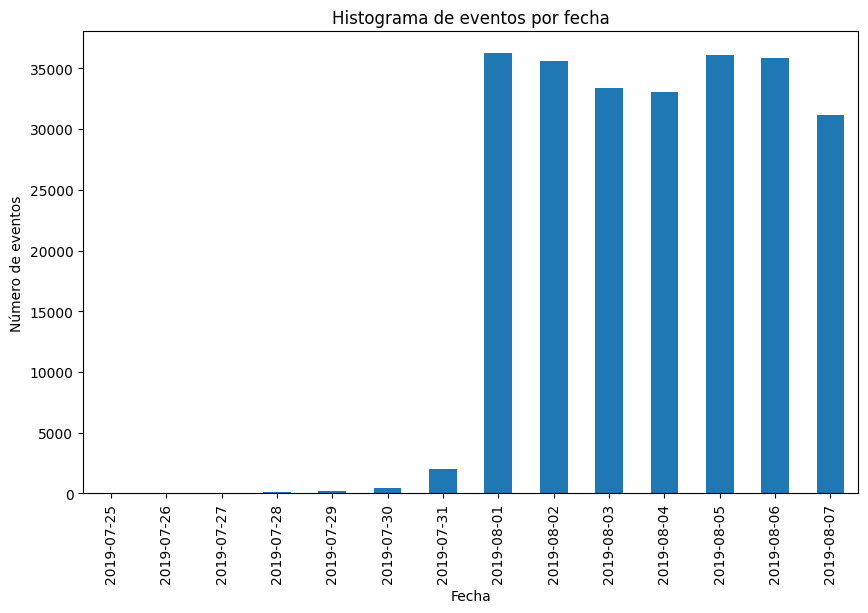

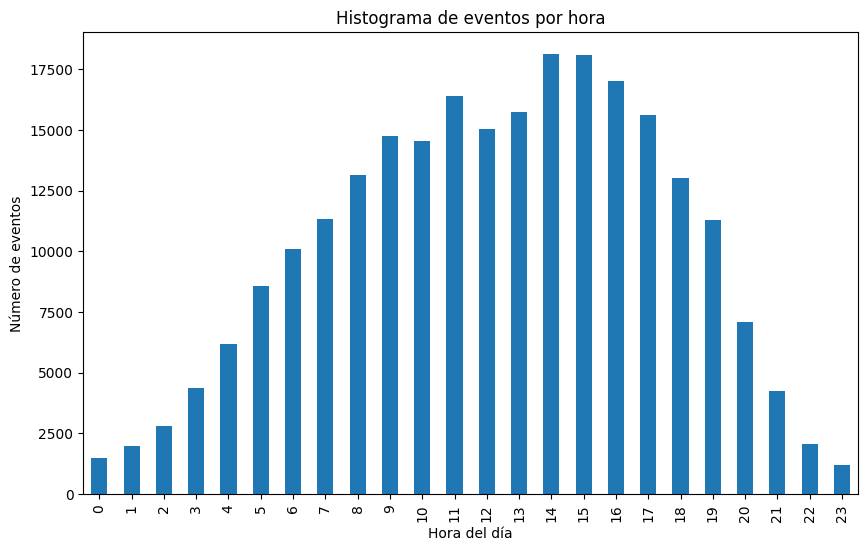

In [4]:
#¿Cuántos eventos hay en los registros?
print(f"Total de eventos: {len(df['evento'])}")
#- ¿Cuántos usuarios hay en los registros?
print(f"Total de usuarios únicos: {df['id_usuario'].nunique()}")
# - ¿Cuál es el promedio de eventos por usuario?
print(f"Promedio de eventos por usuario: {len(df['evento']) / df['id_usuario'].nunique()}")
#fecha máxima y mínima
print(f"Fecha mínima: {df['fecha'].min()}, Fecha máxima: {df['fecha'].max()}")
#histograma por fecha
plt.figure(figsize=(10, 6)) 
df['fecha'].value_counts().sort_index().plot(kind='bar')
plt.title('Histograma de eventos por fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos') 
plt.show()

# Histograma por hora (0-23)
# Creamos una columna solo con la hora (0-23)
df['hora_sola'] = fechas.dt.hour

plt.figure(figsize=(10, 6))
df['hora_sola'].value_counts().sort_index().plot(kind='bar')
plt.title('Histograma de eventos por hora')
plt.xlabel('Hora del día')
plt.ylabel('Número de eventos')
plt.show()

#### El periodo significativo para que no exista un sesgo en el analisis va del 01 de agosto de 2019 al 07 de agosto de 2019 

In [5]:
#- ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
# Filtramos el DataFrame para quedarnos solo con las fechas entre el 01 de agosto de 2019 y el 07 de agosto de 2019
df_filtered = df[(df['fecha'] >= pd.to_datetime('2019-08-01').date()) & (df['fecha'] <= pd.to_datetime('2019-08-07').date())]
print(f"Total de eventos después del filtrado: {len(df_filtered['evento'])}")
#diferencia de eventos
print(f"Diferencia de eventos: {len(df['evento']) - len(df_filtered['evento'])}")
#Diferencia significativa eventos y usuarios
print(f"Diferencia significativa en eventos: {((len(df['evento']) - len(df_filtered['evento'])) / len(df['evento'])) * 100:.2f}%")
print(f"Total de usuarios únicos después del filtrado: {df_filtered['id_usuario'].nunique()}")
print(f"Diferencia de usuarios: {df['id_usuario'].nunique() - df_filtered['id_usuario'].nunique()}")
print(f"Diferencia significativa en usuarios: {((df['id_usuario'].nunique() - df_filtered['id_usuario'].nunique()) / df['id_usuario'].nunique()) * 100:.2f}%")

Total de eventos después del filtrado: 241298
Diferencia de eventos: 2828
Diferencia significativa en eventos: 1.16%
Total de usuarios únicos después del filtrado: 7534
Diferencia de usuarios: 17
Diferencia significativa en usuarios: 0.23%


In [6]:
#- Asegúrate de tener usuarios de los tres grupos experimentales.
print(df_filtered['id_experimento'].value_counts())

id_experimento
248    84726
246    79425
247    77147
Name: count, dtype: int64


##### Despues de realizar un analisis de nuestra informacion filttrada, consideramos que no existe problema alguno con realizar los estudios de hipotesis que queramos más adelante , las diferencias significativas entre los eventos y usuarios antes y despues del filtrado  es de 1.16% y 0.23% respectivamente. 

## Paso 4. Estudiar el embudo de eventos

- Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
- Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. 
- Calcula la proporción de usuarios que realizaron la acción al menos una vez.
- ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.
- Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.
- ¿En qué etapa pierdes más usuarios?
- ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [7]:
#- Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
print("Frecuencia de eventos:")
acciones_x_evento = (df_filtered['evento'].value_counts())
print(acciones_x_evento)
#- Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios.
evento_x_usuario = df_filtered.groupby('evento')['id_usuario'].nunique().sort_values(ascending=False)
print()
print("Cantidad de usuarios por evento:") 
print(evento_x_usuario)

#- Calcula la proporción de usuarios que realizaron la acción al menos una vez.
total_usuarios = df_filtered['id_usuario'].nunique()
proporcion_usuarios_evento = evento_x_usuario / total_usuarios
print()
print("Proporción de usuarios que realizaron la acción al menos una vez:")
print(proporcion_usuarios_evento)
   

Frecuencia de eventos:
evento
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64

Cantidad de usuarios por evento:
evento
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: id_usuario, dtype: int64

Proporción de usuarios que realizaron la acción al menos una vez:
evento
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: id_usuario, dtype: float64


- ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

Considero que el Tutorial va despues de OffersScreenAppear, supongo que lo menten para explicar los beneficios, la via de adminsirtacion y dosis o algo referente a las caracetristicas del alimento, que generalmente una persona cuando consulta un producto como alimento ya sabe el porque lo quiere. 

In [8]:
#Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente.
# Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y 
# la proporción de usuarios en la etapa C a la cantidad en la etapa B.

# Definimos la secuencia de eventos
secuencia_eventos = ['MainScreenAppear', 'OffersScreenAppear', 'Tutorial', 'CartScreenAppear', 'PaymentScreenSuccessful']
# Creamos un diccionario para almacenar la cantidad de usuarios por evento
usuarios_por_evento = {}
# Llenamos el diccionario con conjuntos de usuarios únicos por evento
for evento in secuencia_eventos:
    usuarios_por_evento[evento] = set(df_filtered[df_filtered['evento'] == evento]['id_usuario'].unique())
# Calculamos la proporción de usuarios que pasan de una etapa a la siguiente
#creamos un diccionario para almacenar las proporciones
proporciones = {}   
# Recorremos la secuencia de eventos y calculamos las proporciones
for i in range(len(secuencia_eventos) - 1):
#creamos variables para el evento actual y el siguiente 
    evento_actual = secuencia_eventos[i]
    evento_siguiente = secuencia_eventos[i + 1]
# obtenemos los conjuntos de usuarios para ambos eventos
    usuarios_actual = usuarios_por_evento[evento_actual]
    usuarios_siguiente = usuarios_por_evento[evento_siguiente]
#calculamos la proporción de usuarios que pasan del evento actual al siguiente
    if len(usuarios_actual) > 0: #el 0 evita division por 0 en caso de que no haya usuarios en el evento actual
        #formula de intersección para obtener los usuarios que pasaron de un evento a otro
        proporcion = len(usuarios_siguiente.intersection(usuarios_actual)) / len(usuarios_actual) 
    else:
        proporcion = 0 # Si no hay usuarios en el evento actual, la proporción es 0
    proporciones[f"{evento_actual} -> {evento_siguiente}"] = proporcion
# Mostramos las proporciones
print()
print("Proporción de usuarios que pasan de una etapa a la siguiente:")
for etapa, proporcion in proporciones.items():
    print(f"{etapa}: {proporcion:.2f}") 




Proporción de usuarios que pasan de una etapa a la siguiente:
MainScreenAppear -> OffersScreenAppear: 0.60
OffersScreenAppear -> Tutorial: 0.14
Tutorial -> CartScreenAppear: 0.65
CartScreenAppear -> PaymentScreenSuccessful: 0.95


- Pantalla principal → Ofertas (60.6%)
~6 de cada 10 usuarios que entran a la app llegan a ver las ofertas.

- Ofertas → Tutorial (14.1%)
Muy pocos (solo 1 de cada 7) pasan del área de ofertas al tutorial → podría ser un paso opcional o poco atractivo.

- Tutorial → Carrito (64.7%)
Una vez que ven el tutorial, la mayoría (casi 2 de 3) llegan a añadir algo al carrito.

- Carrito → Pago (94.5%)
La conversión desde carrito hasta compra final es muy alta, lo cual es un gran indicador de que los usuarios que llegan al carrito están bastante decididos a pagar.

In [9]:
#- ¿En qué etapa pierdes más usuarios?
perdida_usuarios = {}
for i in range(len(secuencia_eventos) - 1):
    evento_actual = secuencia_eventos[i]
    evento_siguiente = secuencia_eventos[i + 1]
    usuarios_actual = usuarios_por_evento[evento_actual]
    usuarios_siguiente = usuarios_por_evento[evento_siguiente]
    perdida = len(usuarios_actual) - len(usuarios_siguiente.intersection(usuarios_actual))
    perdida_usuarios[f"{evento_actual} -> {evento_siguiente}"] = perdida    
# Mostramos la pérdida de usuarios por etapa
print()
print("Pérdida de usuarios por etapa:")
for etapa, perdida in perdida_usuarios.items():
    print(f"{etapa}: {perdida} usuarios")



Pérdida de usuarios por etapa:
MainScreenAppear -> OffersScreenAppear: 2937 usuarios
OffersScreenAppear -> Tutorial: 3949 usuarios
Tutorial -> CartScreenAppear: 298 usuarios
CartScreenAppear -> PaymentScreenSuccessful: 200 usuarios


In [10]:
#¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?
usuarios_inicio = usuarios_por_evento['MainScreenAppear']
usuarios_pago = usuarios_por_evento['PaymentScreenSuccessful'] 
porcentaje_completo = (len(usuarios_inicio.intersection(usuarios_pago)) / len(usuarios_inicio)) * 100 if len(usuarios_inicio) > 0 else 0
print()
print(f"Porcentaje de usuarios que hacen todo el viaje desde su primer evento hasta el pago: {porcentaje_completo:.2f}%")



Porcentaje de usuarios que hacen todo el viaje desde su primer evento hasta el pago: 46.38%


### Paso 5. Estudiar los resultados del experimento

In [11]:
#¿Cuántos usuarios hay en cada grupo?

print("Usuarios por grupo experimental:")
usuarios_por_grupo = (
    df_filtered.groupby('id_experimento')['id_usuario'].nunique().reset_index()
)
usuarios_por_grupo.columns = ['experimento', 'usuarios']
print(usuarios_por_grupo)

#Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos.
# Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.
alpha = 0.05
#número de usuarios en cada grupo
grupo_246 = df_filtered[df_filtered['id_experimento'] == 246]['id_usuario'].nunique()
grupo_247 = df_filtered[df_filtered['id_experimento'] == 247]['id_usuario'].nunique()
#numero de usuarios que completaron el proceso de pago en cada grupo #intersección entre los usuarios que completaron el pago y los usuarios de cada grupo
exito_246 = len(usuarios_por_evento['PaymentScreenSuccessful'].intersection(set(df_filtered[df_filtered['id_experimento'] == 246]['id_usuario'].unique())))
exito_247 = len(usuarios_por_evento['PaymentScreenSuccessful'].intersection(set(df_filtered[df_filtered['id_experimento'] == 247]['id_usuario'].unique())))
#realizamos la prueba z
exitos = np.array([exito_246, exito_247])
n = np.array([grupo_246, grupo_247])
stat, p_value = proportions_ztest(exitos, n)
print()
print(f"Resultados de la prueba Z-test entre los grupos 246 y 247:")
print(f"Estadístico de prueba: {stat:.4f}, Valor p: {p_value:.4f}")
if p_value < alpha:
    print("Hay una diferencia estadísticamente significativa entre los grupos (rechazamos H0)")
else:
    print("No hay una diferencia estadísticamente significativa entre los grupos (no rechazamos H0)")    

Usuarios por grupo experimental:
   experimento  usuarios
0          246      2484
1          247      2513
2          248      2537

Resultados de la prueba Z-test entre los grupos 246 y 247:
Estadístico de prueba: 1.5780, Valor p: 0.1146
No hay una diferencia estadísticamente significativa entre los grupos (no rechazamos H0)


- 1. Seleccionar el evento más popular (el más frecuente en el dataset).

- 2. En cada grupo de control (246 y 247):

- 3. Contar usuarios únicos que hicieron ese evento.

- 4. Calcular la proporción respecto al total de usuarios del grupo.

- 5. Aplicar un Z-test de proporciones para ver si hay diferencia significativa.

- 6. Repetir con todos los eventos (lo ideal es usar una función para no repetir código).

- 7. Concluir si los grupos de control están bien divididos (si no hay diferencias significativas).

In [12]:
acciones_x_evento
#utilizamos el datafrme original por si se quisiera comparar otro evento que no esté en el df_filtered
def comparar_evento(df, evento, grupo_a=246, grupo_b=247, alpha=0.05):
    # usuarios de cada grupo
    usuarios_a = set(df[df['id_experimento'] == grupo_a]['id_usuario'].unique())
    usuarios_b = set(df[df['id_experimento'] == grupo_b]['id_usuario'].unique())
    
    # usuarios que hicieron el evento
    exito_a = set(df[(df['id_experimento'] == grupo_a) & (df['evento'] == evento)]['id_usuario'].unique())
    exito_b = set(df[(df['id_experimento'] == grupo_b) & (df['evento'] == evento)]['id_usuario'].unique())
    
    # conversiones y totales # k: es el número de éxitos (usuarios que realizaron el evento), n: es el número total de usuarios
    k_a, k_b = len(exito_a), len(exito_b)
    n_a, n_b = len(usuarios_a), len(usuarios_b)
    # proporciones
    p_a, p_b = k_a/n_a, k_b/n_b
  
    # prueba estadística
    stat, pval = proportions_ztest([k_a, k_b], [n_a, n_b])
    
    return {
        "evento": evento,
        "usuarios_A": n_a, "usuarios_B": n_b,
        "realizaron_A": k_a, "realizaron_B": k_b,
        "prop_A": p_a, "prop_B": p_b,
        "p_valor": pval,
        "significativo": pval < alpha
    }
eventos = df_filtered['evento'].unique()

resultados = [comparar_evento(df_filtered, evento) for evento in eventos]

import pandas as pd
tabla_resultados = pd.DataFrame(resultados)
print(tabla_resultados)


                    evento  usuarios_A  usuarios_B  realizaron_A  \
0                 Tutorial        2484        2513           278   
1         MainScreenAppear        2484        2513          2450   
2       OffersScreenAppear        2484        2513          1542   
3         CartScreenAppear        2484        2513          1266   
4  PaymentScreenSuccessful        2484        2513          1200   

   realizaron_B    prop_A    prop_B   p_valor  significativo  
0           283  0.111916  0.112614  0.937700          False  
1          2476  0.986312  0.985277  0.757060          False  
2          1520  0.620773  0.604855  0.248095          False  
3          1238  0.509662  0.492638  0.228834          False  
4          1158  0.483092  0.460804  0.114567          False  


Esto confirma que los dos grupos A de control están balanceados (correcta asignación aleatoria)

### Ahora realizamos el comparativo pruebas de control A/A sumadas vs B 

In [16]:
#sumamos los dos grupos A de control y los comparamos con el grupo B
df['grupo'] = df['id_experimento'].apply(lambda x: 'A' if x in [246, 247] else 'B')
#vemos la cantidad de usuarios por grupo
usuarios_por_grupo = (
    df.groupby('grupo')['id_usuario'].nunique().reset_index()
)   
print(usuarios_por_grupo)

def comparar_evento_AB(df, evento,alpha=0.05):
    # usuarios de cada grupo
    usuarios_A = set(df[df['grupo'] == 'A']['id_usuario'].unique())
    usuarios_B = set(df[df['grupo'] == 'B']['id_usuario'].unique())
    
    # usuarios que hicieron el evento
    exito_A = set(df[(df['grupo'] == 'A') & (df['evento'] == evento)]['id_usuario'].unique())
    exito_B = set(df[(df['grupo'] == 'B') & (df['evento'] == evento)]['id_usuario'].unique())
    
    # conversiones y totales # k: es el número de éxitos (usuarios que realizaron el evento), n: es el número total de usuarios
    k_A, k_B = len(exito_A), len(exito_B)
    n_A, n_B = len(usuarios_A), len(usuarios_B)
    # proporciones
    p_A, p_B = k_A/n_A, k_B/n_B
  
    # prueba estadística
    stat, pval = proportions_ztest([k_A, k_B], [n_A, n_B])
    
    return {
        "evento": evento,
        "usuarios_A": n_A, "usuarios_B": n_B,
        "realizaron_A": k_A, "realizaron_B": k_B,
        "prop_A": p_A, "prop_B": p_B,
        "p_valor": pval,
        "significativo": pval < alpha
    }
eventos = df_filtered['evento'].unique()
resultados_AB = [comparar_evento_AB(df, evento) for evento in eventos]

tabla_AB = pd.DataFrame(resultados_AB)
print(tabla_AB)


  grupo  id_usuario
0     A        5009
1     B        2542
                    evento  usuarios_A  usuarios_B  realizaron_A  \
0                 Tutorial        5009        2542           565   
1         MainScreenAppear        5009        2542          4938   
2       OffersScreenAppear        5009        2542          3075   
3         CartScreenAppear        5009        2542          2510   
4  PaymentScreenSuccessful        5009        2542          2362   

   realizaron_B    prop_A    prop_B   p_valor  significativo  
0           282  0.112797  0.110936  0.808687          False  
1          2501  0.985826  0.983871  0.506713          False  
2          1538  0.613895  0.605035  0.455540          False  
3          1239  0.501098  0.487411  0.260981          False  
4          1185  0.471551  0.466168  0.657843          False  


In [14]:
#Calcula cuántas pruebas de hipótesis estadísticas has realizado.
num_pruebas = len(eventos) * 2  # 2 comparaciones por evento (A/A y A/B)
print(f"Número total de pruebas de hipótesis realizadas: {num_pruebas}")

Número total de pruebas de hipótesis realizadas: 10


### Resultados principales

Prueba A/A (246 vs 247)

- Ningún evento mostró diferencias estadísticamente significativas.

- Esto confirma que la asignación aleatoria funcionó bien y los grupos de control son equivalentes.

Prueba A vs B (246+247 vs 248)

- En todas las etapas del embudo (Main → Offers → Tutorial → Cart → Payment), las proporciones entre A y B fueron prácticamente iguales.

- Los p-valores fueron altos (mayores a 0.05), lo que significa que no hay evidencia estadística de que el cambio aplicado al grupo B tuviera un efecto real.

Significancia y número de pruebas

- Con varias pruebas de hipótesis, se realizo una corrección Bonferroni
- Usase α = 0.05 como nivel de significancia.

- Con varias pruebas de hipótesis, lo correcto es considerar un ajuste como Bonferroni.

- Incluso con ajuste, los resultados fueron consistentes: no se detectaron efectos significativos.

Conclusión del experimento

✅ El A/A test confirma que la división de usuarios fue correcta.

✅ El experimento B no muestra efectos reales frente al grupo de control.

🚫 No se recomienda implementar los cambios de B, ya que no aportan mejoras.

📌 Decisión: detener el experimento B y mantener la versión original (grupo A).